In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import birth_death_utils as bd
import networkx as nx
from scipy.optimize import fsolve
from tabulate import tabulate

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['pdf.use14corefonts'] = True 

# Analytic results on birth-death model 

Notations:

* $\lambda$ birth rate per node and iteration
* $\mu$ death rate per node and interation
* $\tau$ duration of the active reproduction phase
* $T$ duration of the pure death phase

see _Kendall (1948), On the Generalized Birth-and-Death Model_ (```10.1214/aoms/1177730285```)

In [2]:
def n_avg(l, m, t):
    '''
    Parameters
    ----------
    l : float
        lambda
    m : float
        mu
    t : float
        time.

    Returns
    -------
    float
        average number of living nodes at time t
    '''
    return np.exp((l - m) * t)

def P0(l, m, t):
    '''
    Probability of extinction during active reproduction phase at time t < tau
    '''
    if l != m:
        return m * (n_avg(l,m,t) -1.) /( l * n_avg(l,m,t) - m)
    else:
        return l * t / (1 + l * t)

def P(l, m, n, t):
    '''
    probability that tradition has n living witnesses during active reproduction phase at time t < tau
    '''
    return (1 - P0(l,m,t)) * (1 - eta(l,m,t)) * eta(l,m,t)**(n-1)

def eta(l, m, t):
    return (l / m) * P0(l,m,t)

def extinction_prob(l, m, tau, T):
    '''
    Probability of extinction at tau + T
    
    tau : float
        duration of the active reproduction phase
    T : float
        duration of the pure death phase.
    '''
    return P0(l,m,tau) + (1. - P0(l,m,tau)) * (1. / eta(l,m,tau) - 1.) * (1. / (1. - eta(l,m,tau) * (1. - np.exp(-m*T)) ) - 1.)
    
def avg_surviving_witnesses(l, m, tau, T):
    return np.exp((l-m) * tau) * np.exp(-m*T)

def P_n(l, m, tau, T, n):
    '''
    Probability distribution of the number of living nodes per tree at tau + T
    '''
    K = (1. - P0(l, m, tau)) * (1. / eta(l, m, tau) - 1.) / (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))
    S = ((eta(l, m, tau) * (1 - np.exp(- m * T))) / ((np.exp(m * T) - 1) * (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))))**n
    return K * S


def median(l, m, tau, T):
    '''
    Median number of survivng witnesses
    '''
    K = (1. - P0(l, m, tau)) * (1. / eta(l, m, tau) - 1.) / (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))
    r = (eta(l, m, tau) * (1 - np.exp(- m * T))) / ((np.exp(m * T) -1 ) * (1 - eta(l, m, tau) * (1 - np.exp(- m * T))))
    s = 1 - extinction_prob(l, m, tau, T)
    return np.log((1 - (s / (2 * K) + 1) * (1. - r))) / np.log(r)

def cumul_pop(l, m, tau, T):
    '''
    Total number of nodes generated at tau + T
    '''
    if l != m:
        return 1. + l / (l-m) * (np.exp((l-m) * tau) - 1.)
    else:
        return (1 + l * tau)

def chao1_survival_rate_work(l, m, tau, T):
    '''
    Value of the Chao1 richness estimator on survival rate of trees/traditions
    '''
    return 1 + P_n(l, m, tau, T, 1)**2 / (2 * (1 - extinction_prob(l, m, tau, T) * P_n(l, m, tau, T, 2)) )

def chao1_survival_rate_documents(l, m, tau, T, K_trad):
    '''
    Value of the Chao1 richness estimator on survival rate of nodes
    '''
    f1 = P_n(l, m, tau, T, 1) * K_trad
    f2 = P_n(l, m, tau, T, 2) * K_trad
    func = lambda x: 2*(1+x) * f1  - np.exp((2*f2/f1)*x)
    xs = fsolve(func, 20)[0]
    chao1_docs = (1+xs)
    return chao1_docs

# Generate simulated traditions

We generate a number ```trad_nb``` of trees for each point in parameter space, for $\lambda$ (resp. $\mu$) ranging between ```lambda_min``` (```mu_min```) and ```lambda_max``` (```mu_max```) with ```lambda_mesh``` (```mu_mesh```) distinct values.
Data are stored in ```path``` with distinct directory for each parameter point.
Data can be stored as pickle dump of ```nx.DiGraph``` (```'serialized'```, faster to load within python) or as a csv file (```csv```).

In [10]:
lambda_min=4*10**(-3)
lambda_max=9*10**(-3) 
mu_min=2*10**(-3) 
mu_max=6*10**(-3)

lambda_mesh=10
mu_mesh=10

tau=1000
T=1000

trad_nb=100
path='data'
output_format='serialized'

mu_range = np.linspace(mu_max, mu_min, mu_mesh)
lambda_range = np.linspace(lambda_min, lambda_max, lambda_mesh)

lambda_labels = [r'%.1f'%n for n in (10**(3))*lambda_range]
mu_labels = [r'%.1f'%n for n in (10**(3))*mu_range]

In [ ]:
if not os.path.exists(f'{path}'):
    os.mkdir(f'{path}')

for i in range(mu_mesh):
    for j in range(lambda_mesh):
        for k in range(trad_nb):
            l = lambda_range[j]
            m = mu_range[i]

            point_path = f'{path}/lambda={lambda_labels[j]}_mu={mu_labels[i]}'

            if not os.path.exists(point_path):
                os.mkdir(point_path)

            g = bd.generate_tree(l, m, Nact, Ninact)

            if output_format == 'serialized':
                os.system(f'touch {point_path}/{k}')
                with open(f'{point_path}/{k}', 'wb') as f:
                    pickle.dump(g, f)

            if output_format == 'csv':
                csv_dump(g, f'{point_path}/{k}')

# Plots of phase diagrams

## Survival rates and median witness numbers

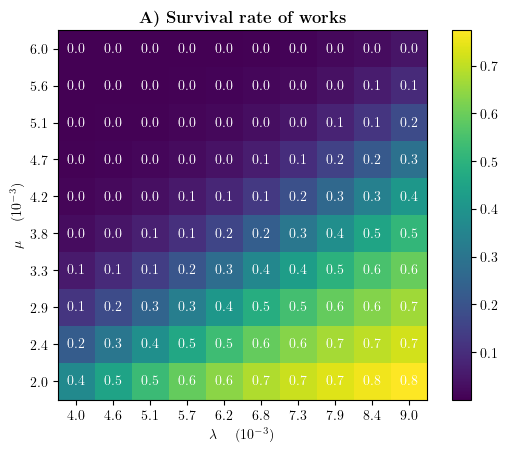

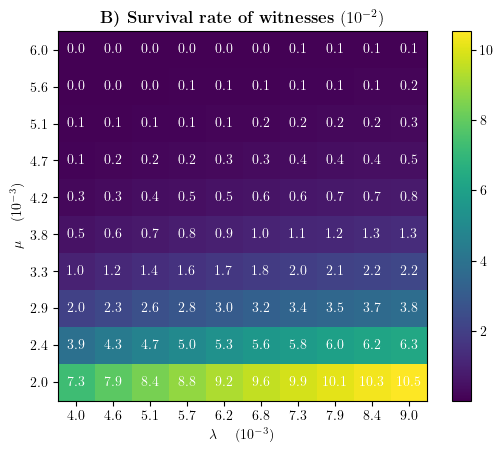

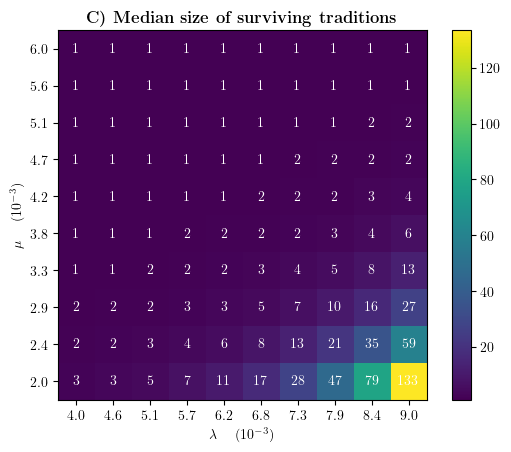

In [4]:
plots = {'srw' : {'data' : [], 'line' : [], 
                      'label' : r'\textbf{A) Survival rate of works}', 'precision' : 1},
             'srm' : { 'data' : [], 'line' : [], 
                      'label' : r'\textbf{B) Survival rate of witnesses} ($10^{-2}$)', 'precision' : 1},
             'msts' : {'data' : [], 'line' : [], 
                       'label' :  r'\textbf{C) Median size of surviving traditions}', 'precision' : 0}}

for i in range(len(mu_range)):
    
    for data in plots.keys():
        plots[data]['line'] = []
            
    for j in range(len(lambda_range)):

        l = lambda_range[j]
        m = mu_range[i]

        plots['srw']['line'].append(1. - extinction_prob(l, m, 1000, 1000))
        plots['msts']['line'].append(median(l, m, 1000, 1000))
        plots['srm']['line'].append(100 * avg_surviving_witnesses(l, m, 1000, 1000) / cumul_pop(l, m, 1000, 1000))
        
    for data in plots.keys():
            plots[data]['data'].append(plots[data]['line'])
    
for plot in plots.values():
    bd.plot_heatmap(plot['data'], plot['label'], lambda_labels, mu_labels, plot['precision'])

## Observables from simulated data

In [28]:
plots= {'median_time_living' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{D) Median birth time of surviving witnesses}', 'precision' : 0},
        'median_time_ow' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{D) Median birth time of oldest witnesses}', 'precision' : 0},
        'dist_gen_arch' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{E) Original - archetype median distance}', 'precision' : 1},
        'bifidity' : {'data' : [], 'line' : [], 
                'label' :  r'\textbf{F) Bifidity probability of stemmata', 'precision' : 1},
        'prob_largest_branch' : {'data' : [], 
                'line' : [], 'label' : r'\textbf{G) Probability to be in heaviest root branch}', 'precision' : 2},
        'total_imbalance' : {'data' : [], 
                'line' : [], 'label' : r'\textbf{G) Total $\beta$ node imbalance}', 'precision' : 2}}

/tmp/ipykernel_115984/241514569.py:77: RankWarning: Polyfit may be poorly conditioned
  beta, _ =  np.polyfit(x, y, 1)


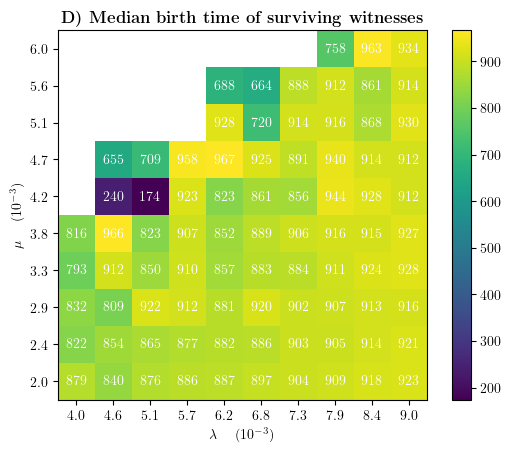

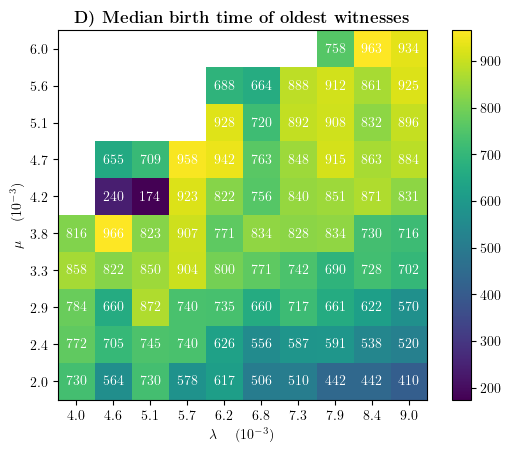

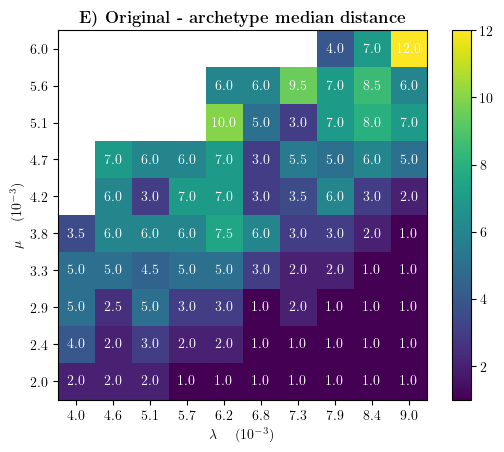

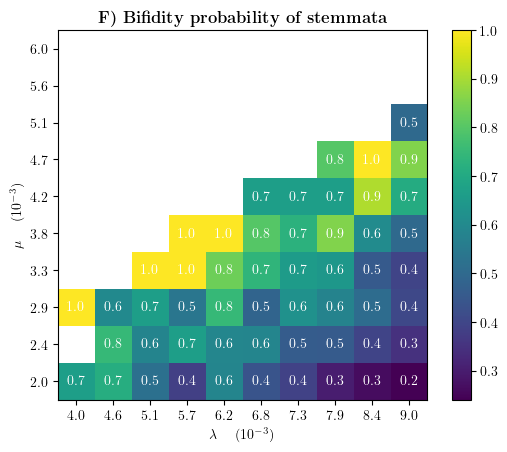

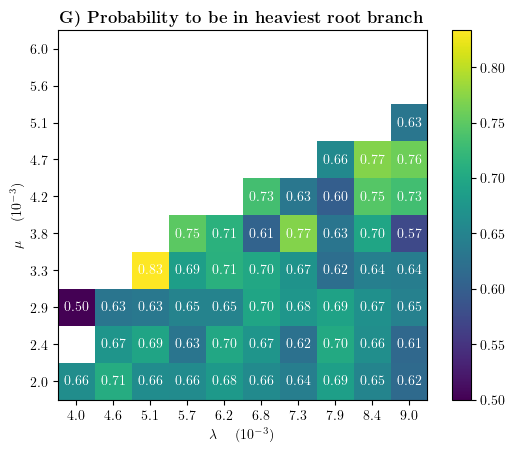

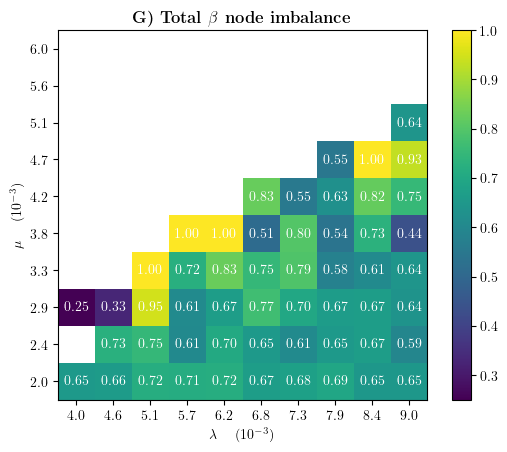

In [29]:
for i in range(len(mu_range)):

    for data in plots.keys():
        plots[data]['line'] = []

    for j in range(len(lambda_range)):

        l = lambda_range[j]
        m = mu_range[i]
        
        trees = []              # all trees at phase diagram point
        living_trees = []       # all trees with at least one surviving witness
        valid_trees = []        # all trees with at least 3 surviving witnesses for stemmata comparisons

        for k in range(trad_nb):
            g = pickle.load(open(f'{path}/lambda={lambda_labels[j]}_mu={mu_labels[i]}/{k}', 'rb'))
            trees.append(g)
            n = list(nx.get_node_attributes(g, 'state').values()).count(True)
            if n >  0:
                living_trees.append(g)
                if n >= 3:
                    valid_trees.append(g)

        # computation of median birth time of all witnesses and oldest witesses

        birth_times = []
        birth_times_ow = []

        for g in living_trees:
            birth_times_trad = []
            for n in g.nodes():
                if g.nodes[n]['state']:
                    birth_times_trad.append(g.nodes[n]['birth_time'])
            birth_times += birth_times_trad
            birth_times_ow.append(min(birth_times_trad))

        plots['median_time_living']['line'].append(np.median(birth_times))
        plots['median_time_ow']['line'].append(np.median(birth_times_ow))

        # computation of archetype original distance in generation

        orig_arch_dists = []

        for g in living_trees:
            st = bd.generate_stemma(g)

            original = bd.root(g)
            archetype = bd.root(st)

            orig_arch_dists.append(len(nx.shortest_path(g, source = original, target = archetype)))

        plots['dist_gen_arch']['line'].append(np.median(orig_arch_dists))

        # computation of root imbalance and total node imbalance

        root_imbalances = []
        node_imbalances = []
        stemmata_sizes = 0
        bifid_stemmata = 0
        
        for g in valid_trees:
            st = bd.generate_stemma(g)
            s = len(list(st.nodes()))
            stemmata_sizes += s
            root_imbalances.append(s*bd.imbalance_root(st))
            node_imbalances += bd.imbalance(st)
            if st.out_degree(bd.root(st)) == 2:
                bifid_stemmata +=1

        if stemmata_sizes > 0:
            plots['prob_largest_branch']['line'].append(sum(root_imbalances) / stemmata_sizes)
        else:
            plots['prob_largest_branch']['line'].append(float('nan'))

        if node_imbalances != []:
            x, y =  list(zip(*node_imbalances))
            beta, _ =  np.polyfit(x, y, 1)
        else:
            beta=float('nan')

        plots['total_imbalance']['line'].append(beta)

        if len(valid_trees) > 0:
            plots['bifidity']['line'].append(bifid_stemmata / len(valid_trees))
        else:
            plots['bifidity']['line'].append(float('nan'))
    for data in plots.keys():
        plots[data]['data'].append(plots[data]['line'])

for plot in plots.values():
    bd.plot_heatmap(plot['data'], plot['label'], lambda_labels, mu_labels, plot['precision'])

# Comparison with real stemmata

Data are obtained from the **OpenStemmata** database (https://openstemmata.github.io/index.html).

Our dataset consists in stemmata of Old French chivalric texts divided in two genre: _Chansons de geste_ (```/chGeste```) and romances (```/romanProse```).

Stemmata, stored as ```.dot``` files, are first loaded and regularized by eliminating contaminations, dubious paternity and mentions of unattested originals or non branching archetypes



In [2]:
def load_from_OpenStemmata(file):
    '''
    returns a nx.DiGraph() tree from database .dot files
    '''
    G = nx.nx_pydot.read_dot(file)
    
    # remove uncertain paternity
    edges_pt = nx.get_edge_attributes(G, 'style')
    for edge, pt in edges_pt.items():
        if pt =='dashed':
            G.remove_edge(*edge)
    
    # remvove singletons and extra-stemmatic contaminations
    singletons = []
    for node in G.nodes():
        if G.in_degree(node) == 0 and G.out_degree(node) == 0:
            singletons.append(node)
    G.remove_nodes_from(singletons)
    
    # remove intra-stemmatic contaminations
    for node in G.nodes():
        in_neighbors = list(G.predecessors(node))
        if G.in_degree(node) > 1:
            contaminations = np.random.choice(in_neighbors, len(in_neighbors) -1, replace=False)
            for parent in contaminations:
                G.remove_edge(parent, node)
    
    # identify survivng witnesses
    colors = nx.get_node_attributes(G, 'color')
    living = {}
    for node in G.nodes():
        if node in colors.keys():
            living[node] = False
        else:
            living[node] = True
    nx.set_node_attributes(G, living, 'state')
    
    # remove non-branching unattested nodes
    st = bd.generate_stemma(G)
    return st

In [3]:
chGeste = {}
for work in os.listdir(f'chGeste/'):
    print(f'{work}')
    st = load_from_OpenStemmata(f'chGeste/{work}/stemma.gv')
    chGeste[f"{work}"] = st

Karsch_1907_Gaydon
Herbin_2018a_Anseys
Nelson_1985_ChevCygne
CourayeduParc_1884_MortAimeri
Zorn_1908_EnfViv
Stimming_1920_BeuveHanstCont3-3
Cloetta_1911_Moniage2
Korte_1914_RenMont2
Nelson_1985_NaissanceChevCygne
Langlois_1888_CourLouis
Nelson_1985_FinElias
Myers_1981_Chetifs1
Stimming_1918_BeuveHanstCont2-3
Gundlach_1883_SiegeBarbastre
Stimming_1920_BeuveHanstCont3-4
Stimming_1920_BeuveHanstCont3-2
Rolin_1897_Aliscans2-Rainouart
Stengel_1882_GarinMonglane
Demaison_1887_Aimeri
Segre_1971_Roland
Grillo_1984_ChretienteCorbaran
Cloetta_1911_Moniage1
Myers_1981_Chetifs2
Treutler_1880_Otinel
Korte_1914_RenMont1
Myers_1981_Chetifs3
Latour_1976_GuiBourgogne1
Korte_1914_RenMont4
Ruelle_1960_HuonBordeaux
Laborderie_1991_FlorentOctavien
Tyssens_1967_PriseOrange
Kerr_1994_AnseisCarthage
Myers_1981_Chetifs4
Stimming_1918_BeuveHanstCont2-1
Stimming_1918_BeuveHanstCont2-4
Tyssens_1967_CourLouis
Tyssens_1967_ EnfVivien
Melander_1922_GuibAndr
Eusebi_1963_ChevOgierDanemarche
Krappe_1939_FlorentOctavien

In [11]:
romanProse = {}
for work in os.listdir(f'romanProse/'):
    print(f'{work}')
    st = load_from_OpenStemmata(f'romanProse/{work}/stemma.gv')
    romanProse[f"{work}"] = st

Leonardi_2003_MortArtu
Heriche_2000_WauquelinAlexandre
Ponceau_1997b_SaintGraal
Zink_1984_Cleriadus
Blanchard_1976_TristanProseV1
Rochebouet_2021_RTroieProse5-2
Veneziale_2020_Guiron-Cont
Clive_1959_FloridanEtElvide
Ponceau_1997c_SaintGraal
Lewis_1915_ApolloniusTyrII
Bogdanow_1991_QuesteTr
Bogdanow_1960_SuiteMerlin
Ponceau_1997a_SaintGraal
Brodtkorb_1965_Pelyarmenus
Hult_2004_Charrette
Coco_2016_SeptSages-A
Keller_1992_FierabrasJeanBagnyon
LeonardiTrachsler_2015_GuironCourtois1
Bogdanow_1991_QuestePV
Niedzielski_1966_Helcanus
Crecy_1997_xPonthus
LeonardiTrachsler_2015_Meliadus1
Rochebouet_2021_RTroieProse5-1
Marchal_2013_Gerard
Kaltenbacher_1904_PLacepede-ParisVienne
Alton_1889_MarquesRome
LeonardiTrachsler_2021_Meliadus1
Lagomarsini_2018_GuironCourtois2
Bogdanow_1991_MortArtuPV
Weidner_1881_JosephArimathieProse
LeonardiTrachsler_2015_GuironCourtois2
Crecy_1997_yPonthus
LeonardiTrachsler_2021_Meliadus2
Lagomarsini_2018_GuironCourtois1


## Topological properties of stemmata

The generalized $\beta$, inspired by Aldous (2001), _Stochastic models and descriptive statistics for phylogenetic trees, from Yule to today_ (```DOI:10.1214/ss/998929474```), is computed for each subset of data, along with the imbalance at the root of the stemma (weighted by the number of witnesses per tradition) and the proportion of bifid trees.

Uncertainty intervals are computed by bootstraping.

In [6]:
@bd.bootstraped
def generalized_beta(trees):
    data = []
    for g in trees:
        data += bd.imbalance(g)
    x, y =  list(zip(*data))
    a, b =  np.polyfit(x, y, 1)
    return a

@bd.bootstraped
def root_imbalance(trees):
    witness_nb_tot = 0
    imbalance_list = []
    for g in trees:
        nb_wit = list(nx.get_node_attributes(g, 'state').values()).count(True)
        imbalance_list.append(nb_wit * bd.imbalance_root(g))
        witness_nb_tot += nb_wit
    return sum(imbalance_list) / witness_nb_tot

@bd.bootstraped
def bifidity(trees):
    nb_bifid = 0
    for g in trees:
        if g.out_degree(bd.root(g)) == 2:
            nb_bifid +=1
    return nb_bifid / len(trees)

## _Chansons de geste_

In [9]:
bif = bifidity(list(chGeste.values()))
root_im = root_imbalance(list(chGeste.values()))
beta_im = generalized_beta(list(chGeste.values()))

results_chGeste = [['observable','estimated value', 'lower bound', 'upper bound'],
                   ['prop. bifid stemmata', f'{bif[0]:.2f}', f'{bif[1]:.2f}', f'{bif[2]:.2f}'],
                   ['root imbalance', f'{root_im[0]:.2f}', f'{root_im[1]:.2f}', f'{root_im[2]:.2f}'],
                   ['beta imbalance', f'{beta_im[0]:.2f}', f'{beta_im[1]:.2f}', f'{beta_im[2]:.2f}']]
                  
print(tabulate(results_chGeste, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════╤═══════════════════╤═══════════════╤═══════════════╕
│ observable           │   estimated value │   lower bound │   upper bound │
╞══════════════════════╪═══════════════════╪═══════════════╪═══════════════╡
│ prop. bifid stemmata │              0.78 │          0.64 │          0.89 │
├──────────────────────┼───────────────────┼───────────────┼───────────────┤
│ root imbalance       │              0.71 │          0.66 │          0.78 │
├──────────────────────┼───────────────────┼───────────────┼───────────────┤
│ beta imbalance       │              0.77 │          0.66 │          0.88 │
╘══════════════════════╧═══════════════════╧═══════════════╧═══════════════╛


## _Romans en prose_

In [12]:
bif = bifidity(list(romanProse.values()))
root_im = root_imbalance(list(romanProse.values()))
beta_im = generalized_beta(list(romanProse.values()))

results_chGeste = [['observable','estimated value', 'lower bound', 'upper bound'],
                   ['prop. bifid stemmata', f'{bif[0]:.2f}', f'{bif[1]:.2f}', f'{bif[2]:.2f}'],
                   ['root imbalance', f'{root_im[0]:.2f}', f'{root_im[1]:.2f}', f'{root_im[2]:.2f}'],
                   ['beta imbalance', f'{beta_im[0]:.2f}', f'{beta_im[1]:.2f}', f'{beta_im[2]:.2f}']]
                  
print(tabulate(results_chGeste, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════╤═══════════════════╤═══════════════╤═══════════════╕
│ observable           │   estimated value │   lower bound │   upper bound │
╞══════════════════════╪═══════════════════╪═══════════════╪═══════════════╡
│ prop. bifid stemmata │              0.8  │          0.59 │          0.97 │
├──────────────────────┼───────────────────┼───────────────┼───────────────┤
│ root imbalance       │              0.75 │          0.68 │          0.83 │
├──────────────────────┼───────────────────┼───────────────┼───────────────┤
│ beta imbalance       │              0.8  │          0.76 │          0.83 │
╘══════════════════════╧═══════════════════╧═══════════════╧═══════════════╛
